In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score,make_scorer
from sklearn.model_selection import GridSearchCV,KFold,cross_val_score,train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
import xgboost
import lightgbm

In [2]:
os.chdir('e:/data set')
plt.rcParams['figure.figsize']=(12,10)

# get data ready
### data explorary analysis

In [3]:
df=pd.read_csv('patients.txt',sep='\t')
df.head()

,patient_id,cancer_type,age,height(in),primary_site,sex,medication
0,5384,blood,44,14,Hodgkin Lymphoma,NaN,Dabrafenib
1,6599,blood,77,12,Hodgkin Lymphoma,NaN,hydrocodone
2,7979,brain,64,42,Brain Tumor,female,oxycodone
3,3498,colon,57,10,colorectal cancer,NaN,Bevacizumb
4,3395,cervix,20,1,cervical cancer,female,Amifostine


### some id are not unqiue, mark them and take a look later on

In [4]:
df.shape

(10086, 7)

In [5]:
pd.unique(df['patient_id']).__len__()  #the patient id are not unique

5724

In [6]:
df_id_groupby=df.groupby('patient_id',as_index=False)['age']
df_id_groupby.count().head()  #here the age refer to count of age

,patient_id,age
0,2002,2
1,2004,2
2,2008,3
3,2010,2
4,2011,4


In [7]:
not_unique_id=df_id_groupby.count().iloc[np.nonzero(df.groupby('patient_id')['age'].count()>1)[0],:]['patient_id']

In [8]:
not_unique_id[:10]  #thoes are the id not unique

0    2002
1    2004
2    2008
3    2010
4    2011
5    2013
6    2017
7    2020
8    2021
9    2022
Name: patient_id, dtype: int64

In [9]:
df.dtypes

patient_id       int64
cancer_type     object
age              int64
height(in)       int64
primary_site    object
sex             object
medication      object
dtype: object

In [10]:
df.describe()

,patient_id,age,height(in)
count,10086.000000,10086.000000,10086.000000
mean,5994.338786,50.074261,42.055126
std,2316.591112,29.286063,24.115664
min,2002.000000,-10.000000,1.000000
25%,3977.000000,24.000000,21.000000
50%,5997.000000,51.000000,42.000000
75%,7988.000000,75.000000,63.000000
max,10000.000000,100.000000,84.000000


# data pre-processing
#### outlier and missing rate

In [11]:
#exam missing value
def missing_rate(data):
    length=data.shape[0]
    Boolean_data=pd.isnull(data)
    result=Boolean_data.apply(lambda x:x.sum()/length,0)
    result=result.sort_values(ascending=False)
    return result

In [12]:
#exam outlier
def index_outlier(data,count=True):
    Q1=data.quantile(0.25)
    Q3=data.quantile(0.75)
    IQR=Q3-Q1
#     print(Q3,Q1,IQR)
    if count:
        return len(np.nonzero(data.apply(lambda x: x>Q3+1.5*IQR or x<Q1-1.5*IQR))[0])
    else:
        return np.nonzero(data.apply(lambda x: x>Q3+1.5*IQR or x<Q1-1.5*IQR))[0]

#### only sex have missing value

In [13]:
missing_rate(df)

sex             0.327285
medication      0.000000
primary_site    0.000000
height(in)      0.000000
age             0.000000
cancer_type     0.000000
patient_id      0.000000
dtype: float64

#### in the common way, there are no outlier, but we also need use domain knowledge to exam further

In [14]:
for col in df.select_dtypes(exclude='O'):
    if col!='patient_id':
        print('Number of outlier for {} is : {}'.format(col,index_outlier(df[col])))
        

Number of outlier for age is : 0
Number of outlier for height(in) is : 0


### age

D:\Python\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


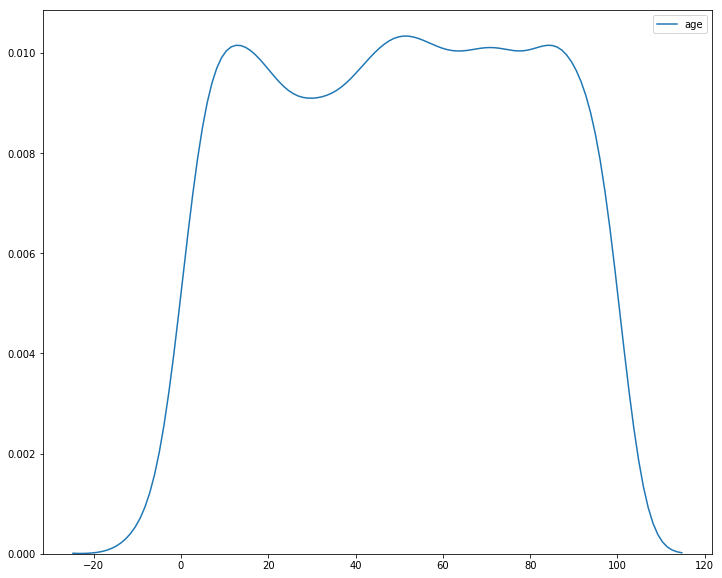

In [15]:
sns.kdeplot(df['age'])

In [16]:
df['age'].describe()

count    10086.000000
mean        50.074261
std         29.286063
min        -10.000000
25%         24.000000
50%         51.000000
75%         75.000000
max        100.000000
Name: age, dtype: float64

In [17]:
df_age_outlier=df[df['age']<=0]
df_age_outlier.head()
#there are 84 row of data have age less than 0

,patient_id,cancer_type,age,height(in),primary_site,sex,medication
93,3257,cervix,-5,21,ribs,male,biotin
278,5114,thyroid,-5,79,Thyroid gland,female,Dacogen
358,7386,prostate,-2,67,prostate cancer,female,Dactinomycin
673,4190,hypopharyngeal cancer,-8,30,Pyriform sinus,female,Amifostine
696,7570,lung,-9,39,Non Small Cell Lung Cancer,male,Lorlatinb


In [18]:
df_age_outlier.describe()

,patient_id,age,height(in)
count,84.000000,84.000000,84.000000
mean,5911.023810,-5.333333,43.571429
std,2084.287096,2.676688,24.718797
min,2255.000000,-10.000000,1.000000
25%,4173.750000,-7.000000,22.750000
50%,5799.500000,-5.000000,47.500000
75%,7553.000000,-3.000000,66.000000
max,9869.000000,-1.000000,81.000000


#### replace the negative age with NAN and then use mode to impute

In [19]:
df['age']=df['age'].apply(lambda x:np.nan if x<=0 else x)
value_impute=np.nanmedian(df['age'])
df['age']=df['age'].fillna(value_impute)

### heights

D:\Python\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


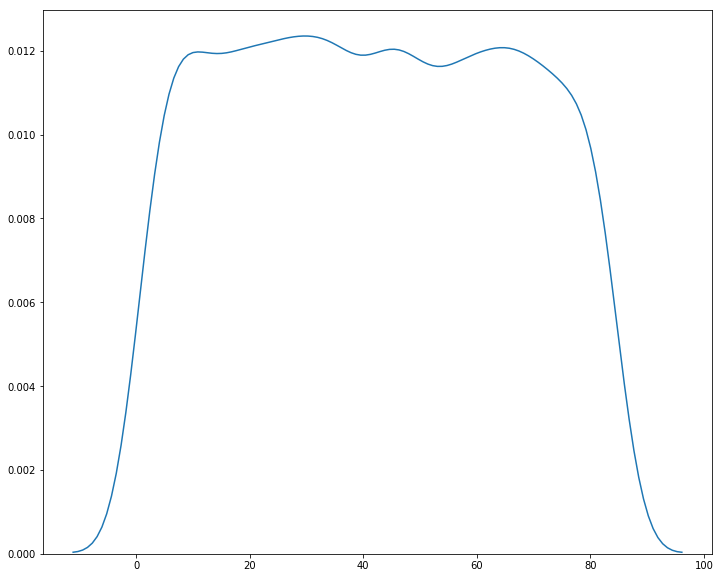

In [20]:
sns.kdeplot(data=df['height(in)'].values)

In [21]:
df['height(in)'].describe()

count    10086.000000
mean        42.055126
std         24.115664
min          1.000000
25%         21.000000
50%         42.000000
75%         63.000000
max         84.000000
Name: height(in), dtype: float64

In [22]:
df[df['height(in)']<10].shape

(1103, 7)

### height and age are closely related together, so it is hard to treat them separatly
### draw plot first and apply anomly detection

In [23]:
df[['age','height(in)']].corr()

,age,height(in)
age,1.000000,-0.014107
height(in),-0.014107,1.000000


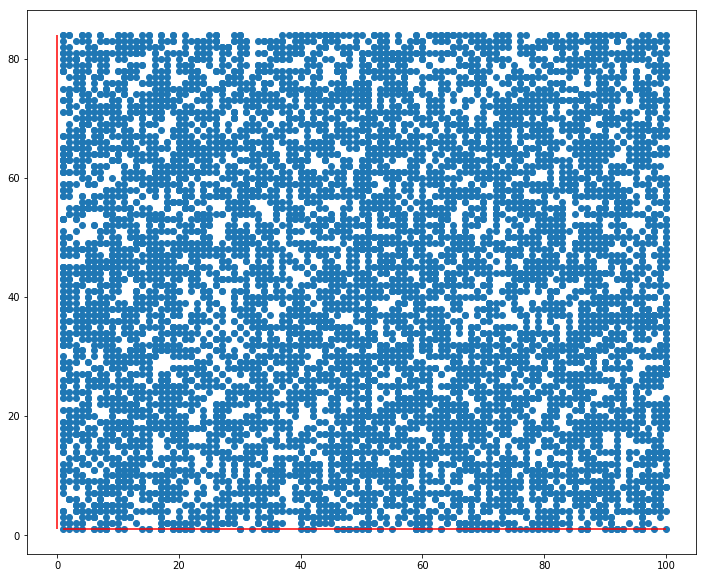

In [24]:
fig,aes=plt.subplots()
plt.scatter(df['age'],df['height(in)'])
plt.hlines(colors='red',xmin=min(df['age']),xmax=max(df['age']),y=1)
plt.vlines(colors='red',ymin=min(df['height(in)']),ymax=max(df['height(in)']),x=0)

### height should have relationship with the age so we impute the height based on its age

In [25]:
#discrete the age(all age now are positive)
age_bin=[-np.inf,3,6,18,30,60,np.inf]

In [26]:
df['age_bin']=pd.cut(df['age'],bins=age_bin)

In [27]:
df.groupby('age_bin')['height(in)'].apply(lambda x:np.median(x))

age_bin
(-inf, 3.0]     41.0
(3.0, 6.0]      44.0
(6.0, 18.0]     41.0
(18.0, 30.0]    45.0
(30.0, 60.0]    42.0
(60.0, inf]     41.0
Name: height(in), dtype: float64

### manually detect the outlier
### basedon the finding from google, we can set up the outlier detection function

In [28]:
def outlier_detector_conservative(line):
    if line['age']<=2 and line['height(in)']>40:
            return np.nan
    elif line['age']>=20 and line['height(in)']<40:
        return np.nan
    else:
        return line['height(in)']

In [29]:
df['height(in)']=df.apply(lambda x:outlier_detector_conservative(x),1)

In [30]:
#no one can have height less than 19.6
df['height(in)']=df['height(in)'].apply(lambda x:np.nan if x<19.6 else x)

In [31]:
#impute height based on the age_range
height_impute=df.groupby('age_bin')['height(in)'].apply(lambda x:np.nanmedian(x)).to_dict()
height_impute

{Interval(-inf, 3.0, closed='right'): 37.0,
 Interval(3.0, 6.0, closed='right'): 55.0,
 Interval(6.0, 18.0, closed='right'): 50.0,
 Interval(18.0, 30.0, closed='right'): 61.0,
 Interval(30.0, 60.0, closed='right'): 62.0,
 Interval(60.0, inf, closed='right'): 61.0}

In [32]:
for i in list(height_impute.keys()):
    df.loc[df['age_bin']==i,'height(in)']=df.loc[df['age_bin']==i,'height(in)'].fillna(height_impute[i])
#     print(df.loc[df['age_bin']==i,'height(in)'])
#     print(height_impute[i])

In [33]:
missing_rate(df)

sex             0.327285
age_bin         0.000000
medication      0.000000
primary_site    0.000000
height(in)      0.000000
age             0.000000
cancer_type     0.000000
patient_id      0.000000
dtype: float64

### sex

In [34]:
LB=LabelEncoder()

In [35]:
df['sex'].value_counts()

female    3428
male      3357
Name: sex, dtype: int64

In [36]:
#it could use fancyimpute but this is a small data set so it is easy to overfit
#i decide to impute with the median and use indicator column to indicate it is missing
df['sex_indicator']=pd.isnull(df['sex'])

In [37]:
df['sex']=df['sex'].fillna('female')

In [38]:
df['sex']=LB.fit_transform(df['sex'])

### medication

In [39]:
df['medication']=LB.fit_transform(df['medication'])

# machine learning


In [40]:
KF=KFold(5)

Counter({'cervix': 812, 'brain': 797, 'hypopharyngeal cancer': 796, 'kidney': 795, 'ovary': 786, 'breast': 785, 'liver': 778, 'blood': 777, 'colon': 768, 'prostate': 747, 'thyroid': 738, 'lung': 734, 'melanoma': 728, 'teeth': 9, 'bone': 8, 'buttock': 8, 'tongue': 7, 'armpit': 7, 'heart': 4, 'feet': 2})


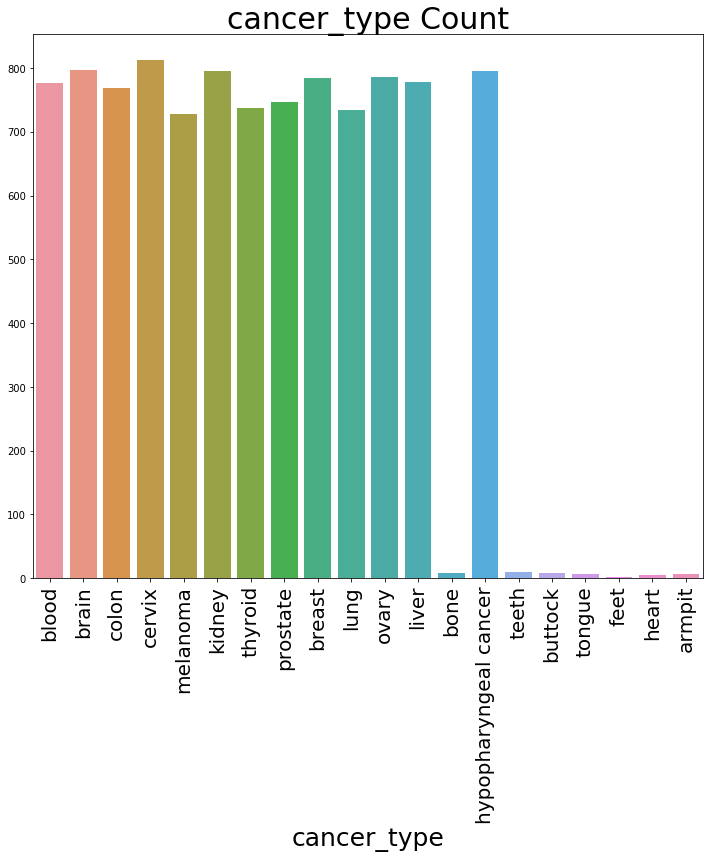

In [41]:
fig,aes=plt.subplots()
C=Counter(df['cancer_type'])
sns.barplot(x=list(C.keys()),y=list(C.values()),ax=aes)
plt.xticks(fontsize=20,rotation=90)
plt.xlabel('cancer_type',fontsize=25)
plt.title('cancer_type Count',fontsize=30)
print(C)

In [42]:
df.head()

,patient_id,cancer_type,age,height(in),primary_site,sex,medication,age_bin,sex_indicator
0,5384,blood,44.0,62.0,Hodgkin Lymphoma,0,7,"(30.0, 60.0]",True
1,6599,blood,77.0,61.0,Hodgkin Lymphoma,0,27,"(60.0, inf]",True
2,7979,brain,64.0,42.0,Brain Tumor,0,30,"(60.0, inf]",False
3,3498,colon,57.0,62.0,colorectal cancer,0,5,"(30.0, 60.0]",True
4,3395,cervix,20.0,61.0,cervical cancer,0,3,"(18.0, 30.0]",False


In [43]:
X=df.drop(columns=['primary_site','age','cancer_type'])
Y=df['cancer_type']

### dsicrete the height

In [44]:
X['height(in)']=pd.qcut(X['height(in)'],q=[0,0.25,0.5,0.75,1])
X['height(in)']=LB.fit_transform(X['height(in)'])

In [45]:
X['age_bin']=LB.fit_transform(X['age_bin'])

In [46]:
X.head()

,patient_id,height(in),sex,medication,age_bin,sex_indicator
0,5384,2,0,7,4,True
1,6599,1,0,27,5,True
2,7979,0,0,30,5,False
3,3498,2,0,5,4,True
4,3395,1,0,3,3,False


### RF

In [47]:
# parameters = {'n_estimators':np.arange(10,100,10), 'max_depth':np.arange(1,4,1),'min_samples_split':np.arange(2,5,1),
#              'min_samples_leaf':np.arange(1,5,1),'max_features':['auto','sqrt','log2']}
# RF = RandomForestClassifier(bootstrap=True)
# clf=GridSearchCV(RF,parameters,cv=3)
# clf.fit(X,Y)
# clf.best_params_

In [48]:
param={'max_depth': 3,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 90}

In [49]:
CLF=RandomForestClassifier(**param)

In [50]:
cross_val_score(CLF,X,Y)

D:\Python\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Python\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


array([0.19922803, 0.19982159, 0.19314456])

In [51]:
CLF.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [52]:
temp=pd.DataFrame({'pred':CLF.predict(X),'truth':Y})
pd.crosstab(temp['pred'],temp['truth'])

truth,armpit,blood,bone,brain,breast,buttock,cervix,colon,feet,heart,hypopharyngeal cancer,kidney,liver,lung,melanoma,ovary,prostate,teeth,thyroid,tongue
pred,,,,,,,,,,,,,,,,,,,,
blood,0,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
brain,0,62,1,122,61,0,56,0,1,1,64,59,0,0,61,65,65,0,55,0
breast,0,22,0,19,39,0,26,0,0,0,33,18,0,0,14,29,20,0,21,0
cervix,1,132,2,124,153,0,187,0,0,1,124,134,0,0,135,147,137,5,124,2
colon,2,160,1,163,163,3,164,404,0,2,175,173,0,256,137,154,149,1,168,3
hypopharyngeal cancer,0,88,1,104,96,1,85,0,0,0,125,89,0,0,94,88,97,0,98,0
kidney,1,112,2,103,100,3,126,0,0,0,111,158,0,0,111,98,96,2,113,2
liver,1,36,0,34,36,0,36,364,1,0,40,31,778,361,35,45,33,1,42,0
lung,2,102,0,82,83,1,78,0,0,0,67,80,0,117,62,66,85,0,70,0


### GBDT

In [53]:
GB = GradientBoostingClassifier(max_depth=2,max_features='sqrt',
                                min_samples_leaf=2,min_samples_split=3,n_estimators=70)
cross_val_score(GB,X,Y,cv=KF)

array([0.29236868, 0.29201785, 0.28854735, 0.28358949, 0.30441249])

In [54]:
GB.fit(X,Y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=2, min_samples_split=3,
              min_weight_fraction_leaf=0.0, n_estimators=70,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [55]:
temp=pd.DataFrame({'pred':GB.predict(X),'truth':Y})
pd.crosstab(temp['pred'],temp['truth'],margins=True)

truth,armpit,blood,bone,brain,breast,buttock,cervix,colon,feet,heart,...,kidney,liver,lung,melanoma,ovary,prostate,teeth,thyroid,tongue,All
pred,,,,,,,,,,,,,,,,,,,,,
armpit,4,2,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,8
blood,0,41,0,10,16,0,13,0,0,0,...,13,0,0,8,12,12,0,18,0,156
bone,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
brain,1,69,0,139,75,0,64,0,0,0,...,83,0,0,69,70,77,0,70,0,791
breast,0,69,0,64,128,0,66,0,0,0,...,66,0,0,63,55,60,0,63,0,705
buttock,0,0,0,0,0,2,0,0,0,0,...,1,0,0,0,1,0,0,0,0,4
cervix,0,161,0,152,169,0,230,0,0,0,...,148,0,0,136,152,145,2,137,2,1578
colon,0,0,0,0,0,0,0,684,0,0,...,0,0,0,0,0,0,0,0,0,684
feet,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


### Xgboost

In [56]:
XGB = xgboost.XGBClassifier(max_depth=1,max_features='auto',
                                min_samples_leaf=1,min_samples_split=2,n_estimators=50,reg_lambda=5)
cross_val_score(XGB,X,Y,cv=KF)

array([0.24182359, 0.23301934, 0.23401091, 0.23996034, 0.24590977])

In [57]:
XGB.fit(X,Y)
temp=pd.DataFrame({'pred':GB.predict(X),'truth':Y})
pd.crosstab(temp['pred'],temp['truth'])

truth,armpit,blood,bone,brain,breast,buttock,cervix,colon,feet,heart,hypopharyngeal cancer,kidney,liver,lung,melanoma,ovary,prostate,teeth,thyroid,tongue
pred,,,,,,,,,,,,,,,,,,,,
armpit,4,2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
blood,0,41,0,10,16,0,13,0,0,0,13,13,0,0,8,12,12,0,18,0
bone,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
brain,1,69,0,139,75,0,64,0,0,0,74,83,0,0,69,70,77,0,70,0
breast,0,69,0,64,128,0,66,0,0,0,71,66,0,0,63,55,60,0,63,0
buttock,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,1,0,0,0,0
cervix,0,161,0,152,169,0,230,0,0,0,144,148,0,0,136,152,145,2,137,2
colon,0,0,0,0,0,0,0,684,0,0,0,0,0,0,0,0,0,0,0,0
feet,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### take a look at those not unique id

In [58]:
# df.sort_values(by='patient_id').head(15)
# #it is hard to know for the duplicate id, which one is valid

In [59]:
# df_not_unique=df.copy()
# for id in not_unique_id:
#     df_not_unique=df_not_unique[df_not_unique.patient_id!=id]

In [60]:
# df_not_unique.head()